In [134]:
import pandas as pd
import pb_functions as pbfs
from importlib import reload

reload(pbfs)
# pd.set_option("display.max_rows", None)

stimuli_list_syl1 = ["NB-DFM/SFM", "NB-SFM/SFM"]
stimuli_list_syl2 = ["BNBl/NB-DFM", "BNBl/NB-SFM"]
stimuli_list_order = ["NB-SFM/SFM", "SFM/NB-SFM"]
stimuli_list_rep = ["NB-DFM222", "NB-DFM555"]
stimuli_list_rep2 = ["NB-SFM/SFM/SFM", "NB-SFM/SFM/SFM/NB-SFM/SFM/SFM"]
stimuli_list_comb = ["NB-SFM/SFM/SFM", "NB-SFM/SFM/NB-SFM"]

group_all_dict = {
    "syl1": stimuli_list_syl1,
    "syl2": stimuli_list_syl2,
    "order": stimuli_list_order,
    "rep": stimuli_list_rep,
    "rep2": stimuli_list_rep2,
    "comb": stimuli_list_comb,
}
bodypart_list = [
    "right_arm",
    "left_arm",
    "right_ear",
    "left_ear",
    "middle_head",
    "mouth",
]


df_all = pd.read_csv("all.csv", index_col=None, header=0)
df_from_rep = pd.read_csv("repetition_all.csv", index_col=None, header=0)

# 从原始数据选出能用的数据
# 结果保存到相应的文件夹和文件中
lh_limit = 0.5
lh_percent  = 0.8
file_path_prefix = "./replaced_data_l"+str(lh_limit)+"_p"+str(lh_percent)+"/"
df_lh_percent = pd.DataFrame(
    columns=[
        "group",
        "stimuli",
        "bodypart",
        "id",
        "bat",
        "lh_good_num",
        "lh_num",
        "ave_mum",
        "lh_percent",
    ]
)
for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_from = df_from_rep
    else:
        df_from = df_all
    for sti in stimuli_list:
        sti_bat_list = df_from[df_from["stimuli"] == sti]["bat"].unique()
        group_sti_duration = []
        for bp in bodypart_list:
            for bat in sti_bat_list:
                # print(sti, bat, bp)
                df_sti_bat_bp = pbfs.get_data_by_bat_sti_bp2(df_from, bat, sti, bp)
                lh_list = df_sti_bat_bp[bp + "likelihood"].values
                lh_good_list = [lh for lh in lh_list if lh > lh_limit]
                if (len(lh_list) > 100) and (len(lh_good_list) / len(lh_list)) > lh_percent:
                    group_sti_duration.append(len(lh_list))
                    good_id = df_sti_bat_bp["id"].values[0]
                    df_lh_percent = pd.concat([
                        df_lh_percent,
                        pd.DataFrame(
                            [   
                                [
                                    group_name,
                                    sti,
                                    bp,
                                    good_id,
                                    bat,
                                    len(lh_good_list),
                                    len(lh_list),
                                    0,
                                    len(lh_good_list) / len(lh_list),
                                ]
                            ],
                            columns=df_lh_percent.columns,
                        ),
                    ], axis=0)
                    # print(group_name, sti, bat, bp, good_id)
            # if len(good_bat_list) >= 3:
            #     lh_percent_list.append([good_bat_list])
        ave_duration = sum(group_sti_duration) / len(group_sti_duration)
        df_lh_percent.loc[
            (df_lh_percent["group"] == group_name) & (df_lh_percent["stimuli"] == sti),
            "ave_num",
        ] = int(ave_duration)
# print(df_lh_percent)
# 所有的相同 stimuli 的时长数据求平均值,加入到 df_lh_percent 中

df_lh_percent.to_csv(file_path_prefix+"lh_percent.csv", index=False)


In [85]:
# 生成echo数据
# 找出需要判断第一个点的数据
df_npaired = pd.read_csv(
    file_path_prefix + "lh_percent.csv",
    index_col=None,
    header=0,
)
df_echo_all = pd.read_excel(
    "../alldata.xlsx", index_col=None, header=0, sheet_name="alldata"
)
# print(df_echo_all.head())
df_echo_rep = pd.read_excel(
    "../playback2017-repetition/playback2017data.xlsx",
    index_col=None,
    header=0,
    sheet_name="graph",
)
df_echo_all_result = pd.DataFrame(columns=["group", "stimuli", "bodypart", "bat", "echo"])

for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_from = df_from_rep
        df_echo_from = df_echo_rep
    else:
        df_from = df_all
        df_echo_from = df_echo_all
    sti_good_bp = []
    for sti in stimuli_list:
        bp_list = df_npaired[
            (df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti)
        ]["bodypart"].tolist()
        sti_bp_bat_list_all = {}

        for bp in list(set(bp_list)):
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            if len(bat_list) >= 3:
                sti_bp_bat_list_all[bp] = len(bat_list)
        # print(group_name, sti, sti_bp_bat_list_all)
        sti_good_bp.append(sti_bp_bat_list_all)
    # print(group_name, sti_good_bp)
    # result_bp_list = list(set(sti_bp_list[0]).intersection(set(sti_bp_list[1])))
    # print(group_name, result_bp_list)
    sti1_bp_list = list(sti_good_bp[0].keys())
    sti2_bp_list = list(sti_good_bp[1].keys())
    shared_bp_list = list(set(sti1_bp_list).intersection(set(sti2_bp_list)))
    group_bp_list = []
    for shared_bp in shared_bp_list:
        sti1_bat_num = sti_good_bp[0][shared_bp]
        sti2_bat_num = sti_good_bp[1][shared_bp]
        if sti1_bat_num + sti2_bat_num >= 8:
            # print(group_name, shared_bp, sti1_bat_num, sti2_bat_num)
            group_bp_list.append(shared_bp)
    print(group_name, group_bp_list)  # 最终的group和bp

    #     for bp in group_bp_list: # 找需要手动选点的 origin x y

    #         for sti in stimuli_list:
    #             bat_list = df_npaired[(df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti) & (df_npaired["bodypart"] == bp)]["bat"].tolist()
    #             # print(group_name, sti, bp, bat_list)
    #             for bat in bat_list: # 找 origin x y
    #                 origin_lh = df_from[(df_from["stimuli"] == sti) & (df_from["bat"] == bat)][bp+"likelihood"][0:5]
    #                 if origin_lh.min() < 0.9:
    #                     bad_origin_id = df_from[(df_from["stimuli"] == sti) & (df_from["bat"] == bat)]["id"].values[0]
    #                     print(group_name, sti, bp, bat, bad_origin_id, origin_lh.tolist())
    #                     # 结果保存到了 nonpaired_originxy.py 文件中

    # 获取 echo 数据，保存到 echo_all_nonpaired.csv 文件中
    for bp in group_bp_list:
        for sti in stimuli_list:
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            for bat in bat_list:
                echo_value = df_echo_from[
                    (df_echo_from["bat"] == bat)
                    & (df_echo_from["stimuli"] == sti)
                    & (df_echo_from["timebin"] == "during")
                ]["echo"].values[0]
                print(group_name, sti, bp, bat, echo_value)
                df_echo_all_result = pd.concat(
                    [
                        df_echo_all_result,
                        pd.DataFrame(
                            [[group_name, sti, bp, bat, echo_value]],
                            columns=df_echo_all_result.columns,
                        ),
                    ],
                    axis=0,
                )
df_echo_all_result.to_csv(file_path_prefix+"echo_all_nonpaired.csv", index=False)
                
    


C:\Users\Andrew\AppData\Local\Temp\ipykernel_30132\380030667.py:8: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_echo_all = pd.read_excel(


syl1 ['mouth', 'right_arm']
syl1 NB-DFM/SFM mouth b777 51.0
syl1 NB-DFM/SFM mouth b99-10 137.0
syl1 NB-DFM/SFM mouth b99-13 103.0
syl1 NB-DFM/SFM mouth b333 114.0
syl1 NB-SFM/SFM mouth b777 102.0
syl1 NB-SFM/SFM mouth b888 160.0
syl1 NB-SFM/SFM mouth 999-JH4384 114.0
syl1 NB-SFM/SFM mouth b99-10 156.0
syl1 NB-SFM/SFM mouth b99-11 118.0
syl1 NB-SFM/SFM mouth b99-12 142.0
syl1 NB-SFM/SFM mouth b99-13 118.0
syl1 NB-SFM/SFM mouth b222 123.0
syl1 NB-SFM/SFM mouth b333 144.0
syl1 NB-DFM/SFM right_arm b777 51.0
syl1 NB-DFM/SFM right_arm 999-JH4384 36.0
syl1 NB-DFM/SFM right_arm b99-10 137.0
syl1 NB-DFM/SFM right_arm b99-11 19.0
syl1 NB-DFM/SFM right_arm b99-12 115.0
syl1 NB-DFM/SFM right_arm b222 195.0
syl1 NB-DFM/SFM right_arm b333 114.0
syl1 NB-SFM/SFM right_arm b777 102.0
syl1 NB-SFM/SFM right_arm b888 160.0
syl1 NB-SFM/SFM right_arm 999-JH4384 114.0
syl1 NB-SFM/SFM right_arm b99-10 156.0
syl1 NB-SFM/SFM right_arm b99-11 118.0
syl1 NB-SFM/SFM right_arm b99-12 142.0
syl1 NB-SFM/SFM right_ar

In [72]:
import nonpaired_originxy as npox
print(npox.nonpaired_originxy)

[{'bat': 'b888', 'originxy': '824_656', 'bodypart': 'right_arm', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b99-13', 'originxy': '1127_759', 'bodypart': 'right_arm', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'c-JH4078', 'originxy': '1105_466', 'bodypart': 'right_arm', 'stimuli': 'SFM/NB-SFM'}, {'bat': 'b99-10', 'originxy': '965_950', 'bodypart': 'mouth', 'stimuli': 'NB-DFM/SFM'}, {'bat': 'b333', 'originxy': '838_798', 'bodypart': 'mouth', 'stimuli': 'NB-DFM/SFM'}, {'bat': 'b777', 'originxy': '838_798', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b888', 'originxy': '1170_850', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': '999-JH4384', 'originxy': '1211_791', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b99-11', 'originxy': '1041_683', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b222', 'originxy': '1139_768', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b333', 'originxy': '634_819', 'bodypart': 'mouth', 'stimuli': 'NB-SFM/SFM'}, {'bat': 'b555', 'or

In [77]:
# 检查 （repetition 1 组）与（其他组）是否有重复的蝙蝠个体
# 结果发现：每组刺激之间比较时，不会有重复的蝙蝠个体
# 所以，对应 echo 和 bp 数据的时候，不需要考虑重复的蝙蝠个体
rep_sti_list = df_from_rep["stimuli"].unique()
for rep_sti in rep_sti_list:

    rep_bat_list = df_from_rep[df_from_rep["stimuli"] == rep_sti]["bat"].unique()
    print(rep_sti, rep_bat_list)

other_sti_list = df_all["stimuli"].unique()
for other_sti in other_sti_list:

    other_bat_list = df_all[df_all["stimuli"] == other_sti]["bat"].unique()
    print(other_sti, other_bat_list)


NB-DFM222 ['b2-JH4113' 'b2-222' 'b2-111' 'b2-2222' 'b2-333' 'b2-1' 'b2-2' 'b2-3'
 'b2-4' 'b2-5' 'b2-6']
NB-DFM555 ['b2-JH4113' 'b2-222' 'b2-111' 'b2-2222' 'b2-333' 'b2-1' 'b2-2' 'b2-3'
 'b2-4' 'b2-5' 'b2-6']
SFM/NB-SFM ['j-010' 'k-011' 'L-012' 'M-JH4382' 'a-001' 'b-B00847' 'c-JH4078'
 'd-JH4371' 'e-JH4113' 'f-006' 'g-JH4054' 'h-FB0197' 'i-009']
BNBl/NB-SFM ['j-010' 'k-011' 'L-012' 'M-JH4382' 'a-001' 'b-B00847' 'c-JH4078'
 'd-JH4371' 'e-JH4113' 'f-006' 'g-JH4054' 'h-FB0197' 'i-009']
BNBl/NB-DFM ['j-010' 'k-011' 'L-012' 'M-JH4382' 'a-001' 'b-B00847' 'c-JH4078'
 'd-JH4371' 'e-JH4113' 'g-JH4054' 'i-009']
NB-SFM/SFM ['b777' 'b888' '999-JH4384' 'b99-10' 'b99-11' 'b99-12' 'b99-13'
 '111-JH4373' 'b222' 'b333' 'b444' 'b555' 'b666']
NB-SFM/SFM/NB-SFM ['b777' 'b888' '999-JH4384' 'b99-10' 'b99-11' 'b99-12' 'b99-13' 'b222'
 'b333' 'b444' 'b555' 'b666']
NB-DFM/SFM ['b777' '999-JH4384' 'b99-10' 'b99-11' 'b99-12' 'b99-13' '111-JH4373'
 'b222' 'b333' 'b444' 'b555' 'b666']
NB-SFM/SFM/SFM ['b777' 'b888' 

In [135]:
reload(pbfs)

df_npaired = pd.read_csv(
    file_path_prefix + "lh_percent.csv",
    index_col=None,
    header=0,
)

for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_from = df_from_rep
    else:
        df_from = df_all

    # print(group_name, stimuli_list)
    sti_bp_list = []
    for sti in stimuli_list:
        bp_list = df_npaired[
            (df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti)
        ]["bodypart"].tolist()
        good_bp_list = []
        for bp in bp_list:
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            if len(bat_list) >= 3:
                good_bp_list.append(bp)
        sti_bp_list.append(good_bp_list)
    result_bp_list = list(set(sti_bp_list[0]).intersection(set(sti_bp_list[1])))
    print(group_name, result_bp_list)

    for bp in result_bp_list:
        bat_bp_list = []
        for sti in stimuli_list:
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            for bat in bat_list:
                # print(group_name, sti, bat, bp)
                bat_bp_list.append([sti, bat, bp])
        saved_filename = group_name + "_" + bp + "_npaird_random_20240411"

        print(group_name, bp, len(bat_bp_list))
        if len(bat_bp_list) >= 8:
            # 生成替换后的数据 例如 syl1.csv rep.csv
            pbfs.save_replaced_data(
                group_name,
                stimuli_list,
                bat_bp_list,
                df_from,
                file_path_prefix,
                saved_filename,
                lh_limit,
                lh_percent,
            )
            # 读取替换后的数据
            data_from = pd.read_csv(
                file_path_prefix + saved_filename + ".csv",
                index_col=None,
                header=0,
            )

            # 生成 group result.csv 和 result_detail.csv
            pbfs.save_result_all(
                group_name,
                bat_bp_list,
                data_from,
                df_from,
                file_path_prefix,
                saved_filename,
            )

            # 非配对比较的统计结果
            df_result_stat = pd.read_csv(file_path_prefix + saved_filename + "_result.csv")
            pbfs.get_npaired_stats(df_result_stat, group_name)


syl1 ['mouth', 'right_arm', 'right_ear']
syl1 mouth 13
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-10 mouth [0.99473983, 0.995671272, 0.995798647, 0.99561286, 0.994741678, 0.995500267, 0.995531261, 0.995532751, 0.916862309, 0.973063707, 0.981274664, 0.960692585, 0.842635155, 0.982935011, 0.999962449]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-12 mouth [0.88340646, 0.886780083, 0.889381111, 0.888462722, 0.902481496, 0.905158103, 0.90515399, 0.905158103, 0.905430794, 0.905424237, 0.905381441, 0.905381441, 0.180745855, 0.999916315, 0.999987006]


TypeError: get_npaired_stats() missing 1 required positional argument: 'file_path_prefix'

In [139]:
reload(pbfs)
pd.set_option("display.max_rows", None)


for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_from = df_from_rep
    else:
        df_from = df_all
    sti_good_bp = []
    for sti in stimuli_list:
        bp_list = df_npaired[
            (df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti)
        ]["bodypart"].tolist()
        sti_bp_bat_list_all = {}

        for bp in list(set(bp_list)):
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            if len(bat_list) >= 3:
                sti_bp_bat_list_all[bp] = len(bat_list)
        # print(group_name, sti, sti_bp_bat_list_all)
        sti_good_bp.append(sti_bp_bat_list_all)

    sti1_bp_list = list(sti_good_bp[0].keys())
    sti2_bp_list = list(sti_good_bp[1].keys())
    shared_bp_list = list(set(sti1_bp_list).intersection(set(sti2_bp_list)))
    group_bp_list = []
    for shared_bp in shared_bp_list:
        sti1_bat_num = sti_good_bp[0][shared_bp]
        sti2_bat_num = sti_good_bp[1][shared_bp]
        if sti1_bat_num + sti2_bat_num >= 8:
            # print(group_name, shared_bp, sti1_bat_num, sti2_bat_num)
            group_bp_list.append(shared_bp)
    print(group_name, group_bp_list)  # 最终的group和bp
    for bp in group_bp_list:
        bat_bp_list = []
        for sti in stimuli_list:
            bat_list = df_npaired[
                (df_npaired["group"] == group_name)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["bodypart"] == bp)
            ]["bat"].tolist()
            for bat in bat_list:
                bat_bp_list.append([sti, bat, bp])
        saved_filename = group_name + "_" + bp + "_npaird_random_20240411"
        pbfs.save_replaced_data(
            group_name,
            stimuli_list,
            bat_bp_list,
            df_from,
            file_path_prefix,
            saved_filename,
            lh_limit,
            lh_percent,
        )
        # 读取替换后的数据
        data_from = pd.read_csv(
            file_path_prefix + saved_filename + ".csv",
            index_col=None,
            header=0,
        )

        # 生成 group result.csv 和 result_detail.csv
        pbfs.save_result_all(
            group_name,
            bat_bp_list,
            data_from,
            df_from,
            file_path_prefix,
            saved_filename,
        )

        # 非配对比较的统计结果
        df_result_stat = pd.read_csv(file_path_prefix + saved_filename + "_result.csv")
        pbfs.get_npaired_stats(df_result_stat, group_name, file_path_prefix)
        pbfs.get_qua_move_stats(df_result_stat, group_name, file_path_prefix)


syl1 ['mouth', 'right_arm']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-10 mouth [0.99473983, 0.995671272, 0.995798647, 0.99561286, 0.994741678, 0.995500267, 0.995531261, 0.995532751, 0.916862309, 0.973063707, 0.981274664, 0.960692585, 0.842635155, 0.982935011, 0.999962449]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-12 mouth [0.88340646, 0.886780083, 0.889381111, 0.888462722, 0.902481496, 0.905158103, 0.90515399, 0.905158103, 0.905430794, 0.905424237, 0.905381441, 0.905381441, 0.180745855, 0.999916315, 0.999987006]


c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['syl1', array(['mouth'], dtype=object), 'ave_1', 'ranksums', 2.1602468994692865, 0.03075356125927459]
['syl1', array(['mouth'], dtype=object), 'ave_10', 'ranksums', 2.1602468994692865, 0.03075356125927459]
['syl1', array(['mouth'], dtype=object), 'ave_20', 'ranksums', 2.1602468994692865, 0.03075356125927459]
['syl1', array(['mouth'], dtype=object), 'ave_25', 'ranksums', 2.1602468994692865, 0.03075356125927459]
['syl1', array(['mouth'], dtype=object), 'acc_ave_1', 'ranksums', 2.1602468994692865, 0.03075356125927459]
['syl1', array(['mouth'], dtype=object), 'up_left', 'f_oneway', 5.338422408952847, 0.04126217511584682]
['syl1', array(['mouth'], dtype=object), 'left_all', 'f_oneway', 13.780013584666339, 0.0034283336841488083]
['syl1', array(['mouth'], dtype=object), 'right_all', 'f_oneway', 10.715159727585274, 0.007420210844340949]
['syl1', array(['mouth'], dtype=object), 'up_all', 'f_oneway', 6.667196737014368, 0.025495092959844024]
['syl1', array(['mouth'], dtype=object), 'down_all', '

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['syl1', array(['right_arm'], dtype=object), 'ave_f1', 'ranksums', -2.6717171358251846, 0.0075464231465723]
syl1 ['right_arm'] b777 qua chi2 20.982329564211035 1 4.635390328779764e-06
syl1 ['right_arm'] b99-12 qua chi2 169.81751179314773 1 8.110056027800478e-39
syl1 ['right_arm'] b99-11 qua chi2 90.97718520894554 1 1.4533826293599035e-21
syl1 ['right_arm'] 999-JH4384 qua chi2 20.891438494094317 1 4.860622205495907e-06
syl1 ['right_arm'] b222 qua chi2 59.89719364550636 1 9.994385830589615e-15
syl1 ['right_arm'] b99-10 qua chi2 88.82040746771636 1 4.323328335300446e-21
syl1 ['right_arm'] b333 qua chi2 164.3868030627862 1 1.2452684038985702e-37
syl2 ['right_arm']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 BNBl/NB-DFM a-001 right_arm [0.9672876, 0.967270076, 0.967285335, 0.96730417, 0.967334509, 0.967334509, 0.967334509, 0.967334509, 0.967273533, 0.966126382, 0.960092247, 0.848100424, 0.805488288, 0.9854967, 0.994544864]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 BNBl/NB-SFM d-JH4371 right_arm [0.991135001, 0.99113

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


syl2 ['right_arm'] M-JH4382 qua chi2 24.76425261573691 1 6.478794629862211e-07
syl2 ['right_arm'] j-010 qua chi2 404.10572417399686 1 7.033659933116395e-90
syl2 ['right_arm'] d-JH4371 qua chi2 24.815469064972568 1 6.308913365548283e-07
syl2 ['right_arm'] i-009 qua chi2 108.09747205067703 1 2.5587967988825937e-25
syl2 ['right_arm'] g-JH4054 qua chi2 44.734528953578646 1 2.2564282270570314e-11
syl2 ['right_arm'] b-B00847 qua chi2 33.034819853867475 1 9.05230657283189e-09
order ['mouth', 'right_arm', 'right_ear']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-10 mouth [0.99473983, 0.995671272, 0.995798647, 0.99561286, 0.994741678, 0.995500267, 0.995531261, 0.995532751, 0.916862309, 0.973063707, 0.981274664, 0.960692585, 0.842635155, 0.982935011, 0.999962449]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b99-12 mouth [0.88340646, 0.886780083, 0.889381111, 0.888462722, 0.902481496, 0.905158103, 0.90515399, 0.905158103, 0.905430794, 0.905424237, 0.905381441, 0.905381441, 0.180745855, 0.999916315, 0

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


no enough bats for  order ['mouth']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM 999-JH4384 right_arm [0.99999392, 0.99999392, 0.99999392, 0.999996305, 0.999987245, 0.999973655, 0.999878407, 0.999881387, 0.999973059, 0.999969959, 0.999991894, 0.999987006, 0.999987841, 0.002176325, 0.001477135]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 SFM/NB-SFM d-JH4371 right_arm [0.986923158, 0.99932158, 0.997622907, 0.999029517, 0.988098443, 0.999431312, 0.999273956, 0.997584462, 0.997701943, 0.996969521, 0.998965859, 0.999447763, 0.121256851, 0.001444525, 0.008510265]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 SFM/NB-SFM f-006 right_arm [0.999790967, 0.999789774, 0.999808609, 0.999798119, 0.999899626, 0.999869585, 0.999916315, 0.999854088, 0.99976033, 0.999932528, 0.99979645, 0.990726948, 0.53510946, 0.876252413, 0.999271095]
no enough bats for  order ['right_arm']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM b888 right_ear [0.994378388, 0.994995117, 0.995540798, 0.994951606, 0.994382083, 0.994373798, 0.994513392, 0.98670572, 0.99

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['order', array(['right_ear'], dtype=object), 'ave_1', 'f_oneway', 6.1263069105646455, 0.04812137563356657]
['order', array(['right_ear'], dtype=object), 'ave_10', 'f_oneway', 6.3630898039911274, 0.04513342210107013]
['order', array(['right_ear'], dtype=object), 'ave_20', 'f_oneway', 6.763760949474734, 0.04062283121969644]
['order', array(['right_ear'], dtype=object), 'acc_ave_1', 'f_oneway', 7.596758869767279, 0.03301866492297848]
['order', array(['right_ear'], dtype=object), 'acc_ave_10', 'f_oneway', 9.178687965663178, 0.023108765938211213]
no enough bats for  order ['right_ear']
rep ['mouth', 'right_arm', 'left_arm']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-DFM555 b2-4 mouth [0.982028246, 0.921585143, 0.998715639, 0.981241584, 0.995662034, 0.20347546, 0.005690182, 0.007590688, 0.006773908, 0.005756452, 0.006632132, 0.008444641, 0.009590012, 0.01092867, 0.005948328]
['rep', array(['mouth'], dtype=object), 'up_all', 'f_oneway', 6.650984221532749, 0.041828446836236474]
rep ['mouth'] b2-JH4113 

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-DFM555 b2-333 right_arm [0.874506354, 0.745965302, 0.876601994, 0.820324481, 0.534626186, 0.664300323, 0.46567148, 0.352815449, 0.498010725, 0.514119029, 0.646468043, 0.845872581, 0.907914221, 0.853438795, 0.86143595]


c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['rep', array(['right_arm'], dtype=object), 'down_all', 'f_oneway', 5.189740869346683, 0.04182159350762256]
rep ['right_arm'] b2-2222 qua chi2 70.69644764957266 1 4.1664201392528637e-17
rep ['right_arm'] b2-5 qua chi2 179.47997862979693 1 6.294525063807114e-41
rep ['right_arm'] b2-JH4113 qua chi2 442.4614281804627 1 3.153174017108648e-98
rep ['right_arm'] b2-3 qua chi2 99.13057613493064 1 2.3639019652524397e-23
down_all ['right_arm'] self_duration TtestResult(statistic=-3.884057139517102, pvalue=0.011594286914655794, df=5)
down_all ['right_arm'] ave_duration TtestResult(statistic=-3.815679140870747, pvalue=0.012427793998900028, df=5)
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-DFM222 b2-3 left_arm [0.945538759, 0.907655776, 0.974592805, 0.94561398, 0.985996306, 0.75520575, 0.554299772, 0.634894013, 0.84505111, 0.842542887, 0.954966187, 0.489815414, 0.509877443, 0.835216105, 0.969004273]
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-DFM555 b2-2 left_arm [0.998982489, 0.99997139, 0.999711931, 0.98190099, 0.9643

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


rep ['left_arm'] b2-JH4113 qua chi2 19.63210403202207 1 9.387846488990854e-06
rep ['left_arm'] b2-2 qua chi2 9.44351446280992 1 0.002118970593543672
rep ['left_arm'] b2-4 qua chi2 22.44556061152974 1 2.161845748078186e-06
ave_f3 ['left_arm'] self_duration TtestResult(statistic=7.242250976322865, pvalue=0.018537219983886334, df=2)
ave_f3 ['left_arm'] ave_duration TtestResult(statistic=7.132694241728424, pvalue=0.019094716638492715, df=2)
rep2 ['right_arm']


c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['rep2', array(['right_arm'], dtype=object), 'down_left', 'f_oneway', 5.656224844958141, 0.036612118292186996]
rep2 ['right_arm'] b99-11 qua chi2 7.599079854561102 1 0.005839809653862497
rep2 ['right_arm'] 999-JH4384 qua chi2 156.76316939099254 1 5.7663472546386696e-36
rep2 ['right_arm'] b99-12 qua chi2 103.62111435020483 1 2.4495272695040745e-24
rep2 ['right_arm'] b99-12 movement chi2 10.765183168170655 3 0.013065805824834553
rep2 ['right_arm'] b99-10 qua chi2 10.355254931443937 1 0.0012910663465209233
qua3 ['right_arm'] self_duration TtestResult(statistic=-3.604413599963272, pvalue=0.03664779997686041, df=3)
qua3 ['right_arm'] ave_duration TtestResult(statistic=-3.820342357566911, pvalue=0.031565997205529585, df=3)
comb ['right_arm']
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM/NB-SFM b888 right_arm [0.999819577, 0.999817312, 0.999816716, 0.999818861, 0.999819458, 0.999823511, 0.999820292, 0.999820888, 0.999631405, 0.899760544, 0.99987638, 0.999950767, 0.999991775, 0.99999404, 0.99999463

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


['comb', array(['right_arm'], dtype=object), 'ave_1', 'f_oneway', 6.788602295672373, 0.020754159087354392]
['comb', array(['right_arm'], dtype=object), 'ave_10', 'f_oneway', 6.638562767461601, 0.021956493526650273]
['comb', array(['right_arm'], dtype=object), 'ave_20', 'f_oneway', 6.53045102704509, 0.022873192055287674]
['comb', array(['right_arm'], dtype=object), 'ave_25', 'f_oneway', 6.580335072179992, 0.022444790913619086]
['comb', array(['right_arm'], dtype=object), 'acc_ave_1', 'ranksums', -2.386235036005218, 0.01702186842010649]
['comb', array(['right_arm'], dtype=object), 'acc_ave_10', 'ranksums', -2.1693045781865616, 0.030059567892412428]
['comb', array(['right_arm'], dtype=object), 'acc_ave_25', 'ranksums', -2.1693045781865616, 0.030059567892412428]
comb ['right_arm'] b99-11 qua chi2 54.09344868806795 1 1.9117761763226196e-13
comb ['right_arm'] b222 qua chi2 386.3925093049126 1 5.0494212225643515e-86
comb ['right_arm'] b99-10 qua chi2 48.27900821047775 1 3.6968864543333545e-12

In [113]:
from scipy.stats import normaltest, ranksums, levene, f_oneway

reload(pbfs)
# echo 数据统计分析 lh_limit=0.5 lh_percent=0.8
# nopaired echo 数据统计分析
df_echo_all = pd.read_csv("echo_all_nonpaired.csv", index_col=None, header=0)
# print(df_echo_all.head())
sig_list = []
for group_name, stimuli_list in group_all_dict.items():
    sti_echo_list = []
    for sti in stimuli_list:
        bat_list = df_echo_all[
            (df_echo_all["group"] == group_name) & (df_echo_all["stimuli"] == sti)
        ]["bat"].unique()
        echo_list = []
        for bat in bat_list:
            echo_value = df_echo_all[
                (df_echo_all["group"] == group_name)
                & (df_echo_all["stimuli"] == sti)
                & (df_echo_all["bat"] == bat)
            ]["echo"].values[0]
            duration = df_npaired[
                (df_npaired["bat"] == bat)
                & (df_npaired["stimuli"] == sti)
                & (df_npaired["group"] == group_name)
            ]["lh_num"].values[0]
            echo_list.append(echo_value/duration)
            # print(group_name, sti, bat, echo_value, duration)
        sti_echo_list.append(echo_list)
    # print(group_name, sti, sti_echo_list)

    norm_list = sti_echo_list[0] + sti_echo_list[1]
    norm_stat, norm_p = normaltest(norm_list)
    if norm_p < 0.05:
        ranksums_stat, ranksums_p = ranksums(sti_echo_list[0], sti_echo_list[1])
        # print(group, param, "ranksums p: ", ranksums_p)
        if ranksums_p < 0.05:
            sig_list.append([group_name, "echo", "ranksums", ranksums_stat, ranksums_p])
    else:
        lev_stat = levene(sti_echo_list[0], sti_echo_list[1])
        if lev_stat.pvalue < 0.05:
            ranksums_stat, ranksums_p = ranksums(sti_echo_list[0], sti_echo_list[1])
            # print(group_name, "echo", "ranksums p: ", ranksums_p)
            if ranksums_p < 0.05:
                sig_list.append([group_name, "echo", "ranksums", ranksums_stat, ranksums_p])
        else:
            f_stat, f_p = f_oneway(sti_echo_list[0], sti_echo_list[1])
            # print(df_sti1, sti_echo_list[1])
            # print(group_name, "echo", "f_oneway p: ", f_p)
            if f_p < 0.05:
                sig_list.append([group_name, "echo", "f_oneway", f_stat, f_p])
print(sig_list)


[['comb', 'echo', 'f_oneway', 6.816872331282576, 0.020536284976389346]]


c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


229.96


In [183]:
# echo 的数据分析不应该根据 good bp, 而是根据所有的 bp,只要回放实验成功了即可
df_echo_all = pd.read_excel(
    "../alldata.xlsx", index_col=None, header=0, sheet_name="alldata"
)
# print(df_echo_all.head())
df_echo_rep = pd.read_excel(
    "../playback2017-repetition/playback2017data.xlsx",
    index_col=None,
    header=0,
    sheet_name="graph",
)
df_npaired = pd.read_csv(
    file_path_prefix + "lh_percent.csv",
    index_col=None,
    header=0,
)
sig_list = []
for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_echo_from = df_echo_rep
    else:
        df_echo_from = df_echo_all
    sti_echo_list = []
    for sti in stimuli_list:
        bat_list = df_echo_from[
            (df_echo_from["stimuli"] == sti) & (df_echo_from["timebin"] == "during")
        ]["bat"].tolist()

        echo_value = df_echo_from[
            (df_echo_from["stimuli"] == sti) & (df_echo_from["timebin"] == "during")
        ]["echo"].tolist()

        # if sti == "BNBl/NB-DFM" and "c-JH4078" in bat_list:
        #     bat_index = bat_list.index("c-JH4078")
        #     print(bat_index)
        #     echo_value.pop(bat_index)

        # if "h-FB0197" in bat_list:
        #     bat_index = bat_list.index("h-FB0197")
        #     print(bat_index)
        #     echo_value.pop(bat_index)

        ave_duration = df_npaired[
            (df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti)
        ]["ave_num"].values[0]
        print(group_name, sti, echo_value, ave_duration)
        print(bat_list)

        echo_value = [x / ave_duration for x in echo_value if x > 3]
        sti_echo_list.append(echo_value)
    # print(group_name, sti_echo_list)
    norm_list = sti_echo_list[0] + sti_echo_list[1]
    norm_stat, norm_p = normaltest(norm_list)
    if norm_p < 0.05:
        ranksums_stat, ranksums_p = ranksums(sti_echo_list[0], sti_echo_list[1])
        # print(group, param, "ranksums p: ", ranksums_p)
        if ranksums_p < 0.05:
            sig_list.append([group_name, "echo", "ranksums", ranksums_stat, ranksums_p])
    else:
        lev_stat = levene(sti_echo_list[0], sti_echo_list[1])
        if lev_stat.pvalue < 0.05:
            ranksums_stat, ranksums_p = ranksums(sti_echo_list[0], sti_echo_list[1])
            # print(group_name, "echo", "ranksums p: ", ranksums_p)
            if ranksums_p < 0.05:
                sig_list.append(
                    [group_name, "echo", "ranksums", ranksums_stat, ranksums_p]
                )
        else:
            f_stat, f_p = f_oneway(sti_echo_list[0], sti_echo_list[1])
            # print(df_sti1, sti_echo_list[1])
            # print(group_name, "echo", "f_oneway p: ", f_p)
            if f_p < 0.05:
                sig_list.append([group_name, "echo", "f_oneway", f_stat, f_p])
for sig in sig_list:
    print(sig)


syl1 NB-DFM/SFM [51, 0, 36, 137, 19, 115, 103, 10, 195, 114, 64, 63, 118] 232
['b777', 'b888', '999-JH4384', 'b99-10', 'b99-11', 'b99-12', 'b99-13', '111-JH4373', 'b222', 'b333', 'b444', 'b555', 'b666']
syl1 NB-SFM/SFM [102, 160, 114, 156, 118, 142, 118, 72, 123, 144, 126, 126, 177] 229
['b777', 'b888', '999-JH4384', 'b99-10', 'b99-11', 'b99-12', 'b99-13', '111-JH4373', 'b222', 'b333', 'b444', 'b555', 'b666']
syl2 BNBl/NB-DFM [100, 58, 107, 0, 3, 16, 4, 90, 127, 70, 53] 223
['j-010', 'k-011', 'L-012', 'M-JH4382', 'a-001', 'b-B00847', 'c-JH4078', 'd-JH4371', 'e-JH4113', 'g-JH4054', 'i-009']
syl2 BNBl/NB-SFM [130, 48, 145, 45, 53, 76, 34, 63, 130, 23, 100, 227, 79] 224
['j-010', 'k-011', 'L-012', 'M-JH4382', 'a-001', 'b-B00847', 'c-JH4078', 'd-JH4371', 'e-JH4113', 'f-006', 'g-JH4054', 'h-FB0197', 'i-009']
order NB-SFM/SFM [102, 160, 114, 156, 118, 142, 118, 72, 123, 144, 126, 126, 177] 229
['b777', 'b888', '999-JH4384', 'b99-10', 'b99-11', 'b99-12', 'b99-13', '111-JH4373', 'b222', 'b333'

C:\Users\Andrew\AppData\Local\Temp\ipykernel_30132\1823792068.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_echo_all = pd.read_excel(
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [197]:
# rep NB-DFM222 NB-DFM555 DEL 70 
list1 = [66.0, 99.0, 104.0, 69.0, 56.0, 50.0, 72.0, 70.0, 63.0, 93.0, 167.0]
list2 = [152.0, 191.0, 168.0, 148.0, 168.0, 156.0, 151.0, 118.0, 174.0, 219.0]

list1 = [x/198 for x in list1]
list2 = [x/323 for x in list2]

norm_list = list1 + list2
print(normaltest(norm_list))
print(levene(list1, list2))
print(ranksums(list1, list2))
print(f_oneway(list1, list2))


NormaltestResult(statistic=5.794972145487928, pvalue=0.05516171844351652)
LeveneResult(statistic=0.9216824294410727, pvalue=0.34909258283305467)
RanksumsResult(statistic=-2.1125363706585913, pvalue=0.034640469794189374)
F_onewayResult(statistic=2.47253516433074, pvalue=0.13235540526665143)


In [217]:
# echo comparison between group
# 配对比较
from scipy.stats import ttest_rel

for group_name, stimuli_list in group_all_dict.items():
    if group_name == "rep":
        df_echo_from = df_echo_rep
    else:
        df_echo_from = df_echo_all

    sti1_bat_list = df_echo_from[
        (df_echo_from["stimuli"] == stimuli_list[0])
        & (df_echo_from["timebin"] == "during")
    ]["bat"].tolist()
    sti2_bat_list = df_echo_from[
        (df_echo_from["stimuli"] == stimuli_list[1])
        & (df_echo_from["timebin"] == "during")
    ]["bat"].tolist()
    shared_bat_list = list(set(sti1_bat_list).intersection(set(sti2_bat_list)))
    print(group_name, shared_bat_list)

    sti_echo_list = []
    for sti in stimuli_list:
        ave_duration = df_npaired[
            (df_npaired["group"] == group_name) & (df_npaired["stimuli"] == sti)
        ]["ave_num"].values[0]

        bat_echo_list = []
        for bat in shared_bat_list:
            if group_name in ["syl1", "syl2"] and bat not in ["b888", "M-JH4382"]:
                echo_value = df_echo_from[
                    (df_echo_from["stimuli"] == sti)
                    & (df_echo_from["timebin"] == "during")
                    & (df_echo_from["bat"] == bat)
                ]["echo"].values[0]
                bat_echo_list.append(echo_value / ave_duration)
            if group_name in ["rep2", "comb"] and bat not in ["b777"]:
                echo_value = df_echo_from[
                    (df_echo_from["stimuli"] == sti)
                    & (df_echo_from["timebin"] == "during")
                    & (df_echo_from["bat"] == bat)
                ]["echo"].values[0]
                bat_echo_list.append(echo_value / ave_duration)
            if group_name in ["rep"] and bat not in ["b2-JH4113"]:
                echo_value = df_echo_from[
                    (df_echo_from["stimuli"] == sti)
                    & (df_echo_from["timebin"] == "during")
                    & (df_echo_from["bat"] == bat)
                ]["echo"].values[0]
                # print(group_name, sti, bat, echo_value, ave_duration)
                bat_echo_list.append(echo_value / ave_duration)
        sti_echo_list.append(bat_echo_list)

        print(group_name, sti, bat_echo_list)
    print(group_name, ttest_rel(sti_echo_list[0], sti_echo_list[1]))

    #
    #     print(group_name, sti, echo_value, ave_duration)
    #     print(bat_list)

    #     echo_value = [x / ave_duration for x in echo_value if x > 3]
    #     sti_echo_list.append(echo_value)


syl1 ['b777', '111-JH4373', 'b99-12', 'b99-11', 'b99-13', '999-JH4384', 'b888', 'b222', 'b99-10', 'b666', 'b444', 'b555', 'b333']
syl1 NB-DFM/SFM [0.21982758620689655, 0.04310344827586207, 0.4956896551724138, 0.08189655172413793, 0.44396551724137934, 0.15517241379310345, 0.8405172413793104, 0.5905172413793104, 0.5086206896551724, 0.27586206896551724, 0.27155172413793105, 0.49137931034482757]
syl1 NB-SFM/SFM [0.44541484716157204, 0.314410480349345, 0.6200873362445415, 0.5152838427947598, 0.5152838427947598, 0.4978165938864629, 0.537117903930131, 0.6812227074235808, 0.7729257641921398, 0.5502183406113537, 0.5502183406113537, 0.62882096069869]
syl1 TtestResult(statistic=-3.4113547745643493, pvalue=0.005811313554026613, df=11)
syl2 ['a-001', 'e-JH4113', 'M-JH4382', 'L-012', 'k-011', 'j-010', 'd-JH4371', 'g-JH4054', 'i-009', 'c-JH4078', 'b-B00847']
syl2 BNBl/NB-DFM [0.013452914798206279, 0.5695067264573991, 0.4798206278026906, 0.2600896860986547, 0.4484304932735426, 0.40358744394618834, 0.3

In [229]:
import os

# 把所有的 group_result 合并到一起
stimuli_group_all = {
    "syl1": stimuli_list_syl1,
    "syl2": stimuli_list_syl2,
    "order": stimuli_list_order,
    "rep2": stimuli_list_rep2,
    "comb": stimuli_list_comb,
    "rep": ["NB-DFM222", "NB-DFM555"],
}
# print(stimuli_group_all)
# print(df_result.columns)
# df_group_result_all = pd.DataFrame(columns=df_result.columns)
# for group in stimuli_group_all.keys():
#     df_group = pd.read_csv(
#         "./replaced_data_l50_p90/" + group + "_result.csv", index_col=None, header=0
#     )
#     df_group_result_all = pd.concat([df_group_result_all, df_group])

# df_group_result_all.to_csv("./replaced_data_l50_p90/all_group_result.csv", index=False)
columns_need = pd.read_csv(
    "./replaced_data_l0.5_p0.8/comb_right_arm_npaird_random_20240411_result.csv",
    index_col=None,
    header=0,
).columns
file_list = os.listdir("./replaced_data_l0.5_p0.8/")
df_group_result_all = pd.DataFrame(columns=columns_need)
for file in file_list:
    if "result.csv" in file and "detail" not in file:
        print(file)
        df_group = pd.read_csv(
            "./replaced_data_l0.5_p0.8/" + file, index_col=None, header=0
        )
        df_group_result_all = pd.concat(
            [df_group_result_all, df_group], axis=0
        )
# df_group_result_all.to_csv(
#     "./replaced_data_l0.5_p0.8/all_group_result.csv",
#     mode="a",
#     index=False,
# )


comb_right_arm_npaird_random_20240411_result.csv
order_mouth_npaird_random_20240411_result.csv
order_right_arm_npaird_random_20240411_result.csv
order_right_ear_npaird_random_20240411_result.csv
rep2_right_arm_npaird_random_20240411_result.csv
rep_left_arm_npaird_random_20240411_result.csv
rep_mouth_npaird_random_20240411_result.csv
rep_right_arm_npaird_random_20240411_result.csv
syl1_mouth_npaird_random_20240411_result.csv
syl1_right_arm_npaird_random_20240411_result.csv
syl2_right_arm_npaird_random_20240411_result.csv


In [5]:
import pandas as pd
# 将 回放时长数据 加入到 all_group_result.csv 中
df_lh_percent = pd.read_csv("./replaced_data_l0.5_p0.8/lh_percent.csv", index_col=None, header=0)
df_group_result_all = pd.read_csv("./replaced_data_l0.5_p0.8/all_group_result.csv", index_col=None, header=0)

for idx, row in df_lh_percent.iterrows():
    for ind, row_result in df_group_result_all.iterrows():
        if (
            row["group"] == row_result["group"]
            and row["stimuli"] == row_result["stimuli"]
            and row["bodypart"] == row_result["bodypart"]
            and row["bat"] == row_result["bat"]
        ):
            df_group_result_all.loc[ind, "lh_num"] = row["lh_num"]
            df_group_result_all.loc[ind, "ave_num"] = row["ave_num"]
        
        if row_result["group"] == "syl1":
            df_group_result_all.loc[ind, "group_order"] = "aSyllable 1"
        if row_result["group"] == "syl2":
            df_group_result_all.loc[ind, "group_order"] = "bSyllable 2"
        if row_result["group"] == "order":
            df_group_result_all.loc[ind, "group_order"] = "cOrder"
        if row_result["group"] == "rep":
            df_group_result_all.loc[ind, "group_order"] = "dRepetition 1"
        if row_result["group"] == "rep2":
            df_group_result_all.loc[ind, "group_order"] = "eRepetition 2"
        if row_result["group"] == "comb":
            df_group_result_all.loc[ind, "group_order"] = "fCombination"

        if row_result["stimuli"] == "NB-DFM222":
            df_group_result_all.loc[ind, "stimuli_order"] = "(NB-DFM)2"
        elif row_result["stimuli"] == "NB-DFM555":
            df_group_result_all.loc[ind, "stimuli_order"] = "(NB-DFM)5"
        elif row_result["stimuli"] == "NB-SFM/SFM/SFM/NB-SFM/SFM/SFM":
            df_group_result_all.loc[ind, "stimuli_order"] = "(NB-SFM/SFM/SFM)2"
        else:
            df_group_result_all.loc[ind, "stimuli_order"] = row_result["stimuli"]



df_group_result_all.to_csv("./replaced_data_l0.5_p0.8/all_group_result_new.csv", index=False)


In [13]:
# 选出 配对比较的数据用于R作图

df_group_result_all = pd.read_csv(
    "./replaced_data_l0.5_p0.8/all_group_result_new.csv", index_col=None, header=0
)
group_list = [
    "aSyllable 1",
    "bSyllable 2",
    "cOrder",
    "dRepetition 1",
    "eRepetition 2",
    "fCombination",
]
df_group_result_all_r = pd.DataFrame(columns=df_group_result_all.columns)
for group in group_list:
    bp_list = df_group_result_all[df_group_result_all["group_order"] == group][
        "bodypart"
    ].unique()
    for bp in bp_list:
        sti_list = df_group_result_all[
            (df_group_result_all["group_order"] == group)
            & (df_group_result_all["bodypart"] == bp)
        ]["stimuli_order"].unique()

        shared_bat_list = []
        for sti in sti_list:
            bat_list = df_group_result_all[
                (df_group_result_all["group_order"] == group)
                & (df_group_result_all["bodypart"] == bp)
                & (df_group_result_all["stimuli_order"] == sti)
            ]["bat"].tolist()
            shared_bat_list.append(bat_list)
        shared_bat_list = list(
            set(shared_bat_list[0]).intersection(set(shared_bat_list[1]))
        )
        print(group, bp, shared_bat_list)
        if len(shared_bat_list) >= 3: # 共享蝙蝠数量大于等于3
            for bat in shared_bat_list:
                df_group_result_all_r = pd.concat(
                    [
                        df_group_result_all_r,
                        df_group_result_all[
                            (df_group_result_all["group_order"] == group)
                            & (df_group_result_all["bodypart"] == bp)
                            & (df_group_result_all["bat"] == bat)
                        ],
                    ],
                    axis=0,
                )
# 加入 order 组数据
df_group_result_all_r = pd.concat(
    [
        df_group_result_all_r,
        df_group_result_all[
            (df_group_result_all["group_order"] == "cOrder")
        ],
    ],
    axis=0,
)
df_group_result_all_r.to_csv(
    "./replaced_data_l0.5_p0.8/all_group_result_paired.csv", index=False
)


aSyllable 1 mouth ['b99-13', 'b333', 'b777', 'b99-10']
aSyllable 1 right_arm ['b99-12', 'b99-11', 'b99-10', 'b222', 'b777', '999-JH4384', 'b333']
bSyllable 2 right_arm ['M-JH4382', 'd-JH4371', 'g-JH4054', 'b-B00847', 'j-010', 'i-009']
cOrder mouth []
cOrder right_arm []
cOrder right_ear []
dRepetition 1 left_arm ['b2-2', 'b2-JH4113', 'b2-4']
dRepetition 1 mouth ['b2-JH4113', 'b2-3']
dRepetition 1 right_arm ['b2-5', 'b2-2222', 'b2-6', 'b2-3', 'b2-JH4113', 'b2-1']
eRepetition 2 right_arm ['999-JH4384', 'b99-12', 'b99-11', 'b99-10']
fCombination right_arm ['b99-11', 'b99-10', 'b222', 'b333', '999-JH4384']


In [22]:
# 选出 其他显著差异的参数 的数据
sig_result_list = [
    ["syl1", "mouth", "ave_1"],
    ["syl1", "mouth", "acc_ave_1"],
    ["syl1", "right_arm", "ave_f1"],
    ["order", "right_ear", "ave_f1"],
    ["order", "right_ear", "acc_ave_1"],
    ["rep", "left_arm", "ave_f3"],
    ["comb", "right_arm", "ave_1"],
    ["comb", "right_arm", "acc_ave_1"],
]
sig_df_r = pd.DataFrame(columns=["group_order", "stimuli_order", "stimuli_num", "bodypart", "bat", "param", "value"])
for sig_result in sig_result_list:
    param_df = df_group_result_all[
        (df_group_result_all["group"] == sig_result[0])
        & (df_group_result_all["bodypart"] == sig_result[1])
    ].loc[:, ["group_order", "stimuli_order", "bodypart", "bat", sig_result[2]]]
    sti_list = param_df["stimuli_order"].unique()
    for ind, sti in enumerate(sti_list):
        param_df.loc[param_df["stimuli_order"] == sti, "stimuli_num"] = ind + 1
    print(param_df)
    param_df_melt = pd.melt(param_df, id_vars=["group_order", "stimuli_order","stimuli_num", "bodypart", "bat"], value_vars=[sig_result[2]], var_name="param", value_name="value")
    print(param_df_melt)
    sig_df_r = pd.concat([sig_df_r, param_df_melt], axis=0)
sig_df_r.to_csv("./replaced_data_l0.5_p0.8/sig_df_r.csv", index=False)

     group_order stimuli_order bodypart         bat      ave_1  stimuli_num
102  aSyllable 1    NB-DFM/SFM    mouth        b777  39.399227          1.0
103  aSyllable 1    NB-DFM/SFM    mouth      b99-10  15.971458          1.0
104  aSyllable 1    NB-DFM/SFM    mouth      b99-13  13.151526          1.0
105  aSyllable 1    NB-DFM/SFM    mouth        b333  13.973036          1.0
106  aSyllable 1    NB-SFM/SFM    mouth        b777  81.893274          2.0
107  aSyllable 1    NB-SFM/SFM    mouth        b888   5.290355          2.0
108  aSyllable 1    NB-SFM/SFM    mouth  999-JH4384   7.817996          2.0
109  aSyllable 1    NB-SFM/SFM    mouth      b99-10  12.174878          2.0
110  aSyllable 1    NB-SFM/SFM    mouth      b99-11   8.870298          2.0
111  aSyllable 1    NB-SFM/SFM    mouth      b99-12   7.326537          2.0
112  aSyllable 1    NB-SFM/SFM    mouth      b99-13   7.462921          2.0
113  aSyllable 1    NB-SFM/SFM    mouth        b222   8.219690          2.0
114  aSyllab

In [55]:
import pandas as pd
from scipy.stats import normaltest, ranksums, levene, f_oneway, kruskal

# 比较 order 组 的 qua23 qua14 和 movement
# 非配对比较，并检测组间组内差异大小

order_param_list = ["qua23", "qua14"] #"qua1", "qua2", "qua3", "qua4", 

df_order_result_all = pd.read_csv(
    "./replaced_data_l0.5_p0.8/all_group_result_new.csv", index_col=None, header=0
)
# print(df_order_result_all.head())
df_lh_percent = pd.read_csv("./replaced_data_l0.5_p0.8/lh_percent.csv", index_col=None, header=0)
df_order = df_order_result_all[df_order_result_all["group_order"] == "cOrder"]
stimuli_list = df_order["stimuli_order"].unique()
bp_list = df_order["bodypart"].unique()

for bp in bp_list:
    # 听到不同刺激的左边跟左边比较，右边跟右边比较
    # 比较百分比，不要直接比较数量，列联表分析只能比较数量？频次？
    
    for param in order_param_list:
        sti_param_list = []
        for sti in stimuli_list:
            bat_list = df_order[(df_order["bodypart"] == bp) & (df_order["stimuli_order"] == sti)]["bat"].tolist()
            bat_param_list = []
            for bat in bat_list:
                self_duration = df_lh_percent[
                    (df_lh_percent["group"] == "order") 
                    & (df_lh_percent["bodypart"] == bp)
                    & (df_lh_percent["stimuli"] == sti)
                    & (df_lh_percent["bat"] == bat)
                ]["lh_num"].values[0] -1
                # print(bp, param, sti, bat, self_duration)
                self_param = df_order[
                    (df_order["bodypart"] == bp)
                    & (df_order["stimuli_order"] == sti)
                    & (df_order["bat"] == bat)
                ][param].values[0]
                self_param_percent = self_param
                bat_param_list.append(self_param_percent)
            sti_param_list.append(bat_param_list)
        print(bp, param, sti_param_list)


        
        

        norm_list = sti_param_list[0] + sti_param_list[1]
        norm_stat, norm_p = normaltest(norm_list)
        if norm_p < 0.05:
            kruskal_stat, kruskal_p = kruskal(sti_param_list[0], sti_param_list[1])
            print(bp, param, "kruskal p: ", kruskal_p)
        else:
            lev_stat = levene(sti_param_list[0], sti_param_list[1])
            if lev_stat.pvalue < 0.05:
                kruskal_stat, kruskal_p = kruskal(sti_param_list[0], sti_param_list[1])
                print(bp, param, "kruskal p: ", kruskal_p)
            else:
                f_stat, f_p = f_oneway(sti_param_list[0], sti_param_list[1])
                print(bp, param, "f_oneway p: ", f_p)


mouth qua23 [[0, 229, 0, 7, 52, 11, 32, 0, 0], [0, 229, 1, 0]]
mouth qua23 kruskal p:  0.8073654220605205
mouth qua14 [[233, 0, 225, 223, 172, 222, 193, 223, 230], [227, 0, 225, 224]]
mouth qua14 kruskal p:  0.7566473862284302
right_arm qua23 [[61, 34, 206, 1, 17, 27, 119, 103, 182, 33, 229], [1, 229, 228, 75, 170, 158, 63, 178, 125, 15]]
right_arm qua23 kruskal p:  0.43828048619897764
right_arm qua14 [[172, 195, 19, 229, 207, 206, 106, 120, 48, 202, 4], [226, 0, 1, 158, 56, 61, 159, 47, 101, 209]]
right_arm qua14 kruskal p:  0.32420657539674064
right_ear qua23 [[6, 176, 76, 35], [1, 23, 0, 12]]
right_ear qua23 kruskal p:  0.08326451666355042
right_ear qua14 [[223, 49, 154, 200], [226, 206, 230, 213]]
right_ear qua14 kruskal p:  0.08326451666355042


c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NB-SFM/SFM b777 right_arm 763.0947266 781.102356
NB-SFM/SFM b888 right_arm 618.0 656
需要手动选择第一帧的原点，检查一下是不是大部分都大于0.9 NB-SFM/SFM 999-JH4384 right_arm [0.99999392, 0.99999392, 0.99999392, 0.999996305, 0.999987245, 0.999973655, 0.999878407, 0.999881387, 0.999973059, 0.999969959, 0.999991894, 0.999987006, 0.999987841, 0.002176325, 0.001477135]
NB-SFM/SFM 999-JH4384 right_arm 926.5338135 769.7947998
NB-SFM/SFM b99-10 right_arm 641.1501465 770.862793
NB-SFM/SFM b99-11 right_arm 705.6219482 660.4679565
NB-SFM/SFM b99-12 right_arm 632.4663696 833.7972412
NB-SFM/SFM b99-13 right_arm 845.25 759
NB-SFM/SFM b222 right_arm 816.6429443 748.7455444
NB-SFM/SFM b333 right_arm 458.6875916 787.7060547
NB-SFM/SFM b444 right_arm 491.9295654 711.3215942
NB-SFM/SFM b555 right_arm 1171.5 680
SFM/NB-SFM j-010 right_arm 612.4717407 426.8833923
SFM/NB-SFM k-011 right_arm 588.75 420
SFM/NB-SFM b-B00847 right_arm 966.1192017 471.5901184
SFM/NB-SFM i-009 right_arm 609.5883789 434.2897034
SFM/NB-SFM L-012 right_arm 80

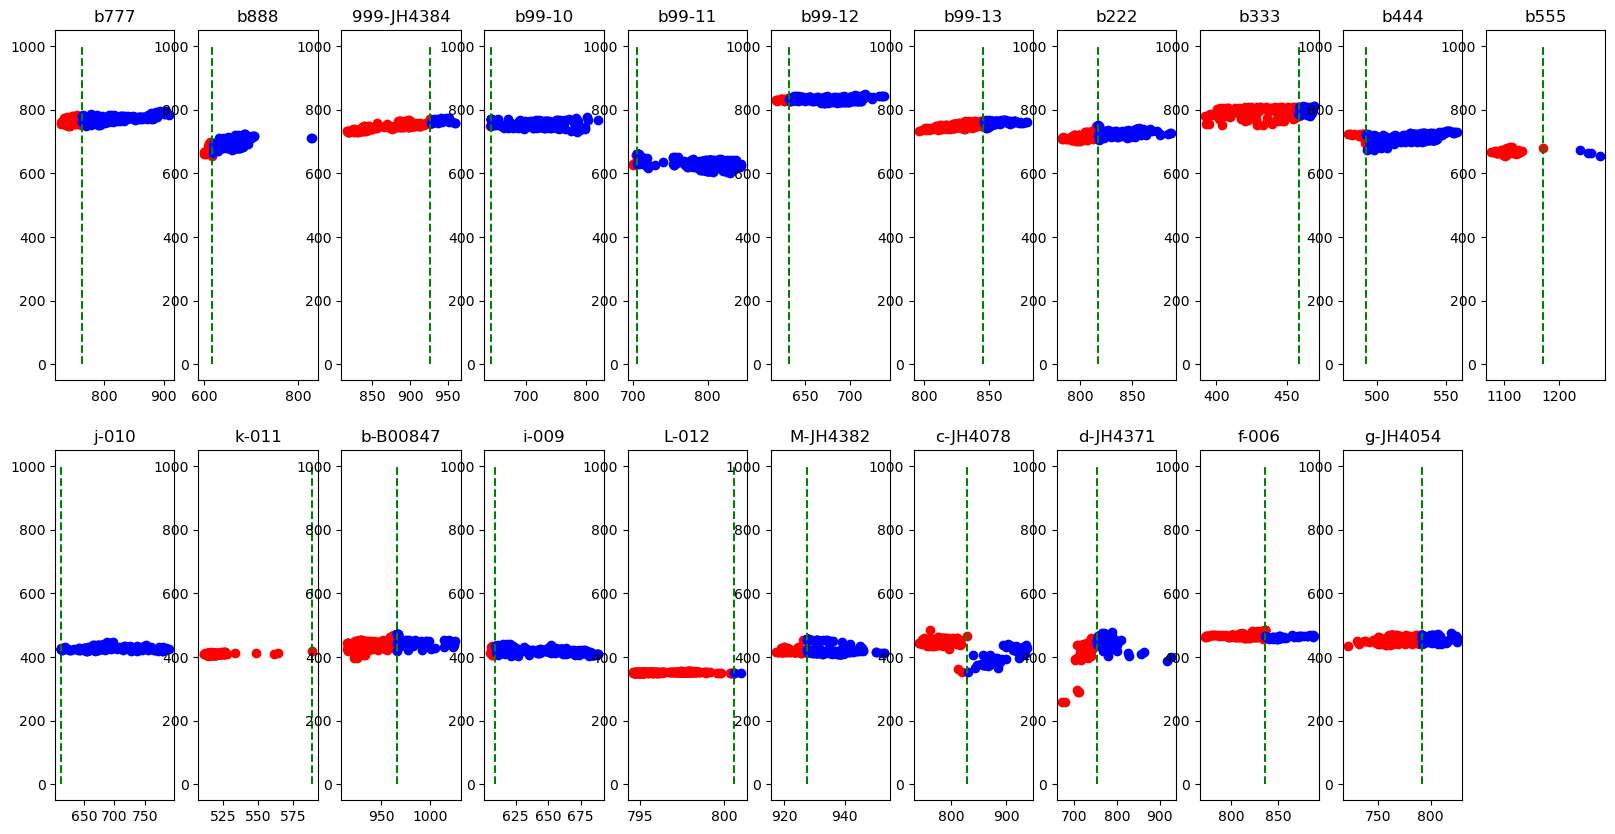

In [25]:
# 检查 order 组的 qua 23 和 qua 14 原始数据
import pb_functions as pbfs
import nonpaired_originxy as npox
from matplotlib import pyplot as plt
# print(npox.order)
# def save_result_all(group_name,bat_bp_list, data_from, origin_df, file_path_prefix, saved_filename):
df_all = pd.read_csv("all.csv", index_col=None, header=0)
# print(df_all.head())

# order_right_arm_npaird_random_20240411.csv #替换后的数据

df_order = df_order_result_all[df_order_result_all["group_order"] == "cOrder"]
stimuli_list = df_order["stimuli_order"].unique()
bp_list = df_order["bodypart"].unique()
df_order_right_arm = pd.read_csv("./replaced_data_l0.5_p0.8/order_right_arm_npaird_random_20240411.csv", index_col=None, header=0)
data_from = df_order_right_arm

order_bat_bp_list = []
for sti in stimuli_list:
    bat_list = df_order[df_order["stimuli_order"] == sti]["bat"].unique()
    for bat in bat_list:
        order_bat_bp_list.append([sti, bat, "right_arm"])

plt.figure(figsize=(20, 10))
sub_id = 1
for bat_bp in order_bat_bp_list:
    sti = bat_bp[0]
    bat = bat_bp[1]
    bodypart = bat_bp[2]
    df_sti_bp = data_from[
        (data_from["stimuli"] == sti)
        & (data_from["bat"] == bat)
        & (data_from["bodypart"] == bodypart)
    ].loc[:, ["x", "y", "likelihood"]]

    # 计算四个象限的数据
    originx, originy = 0, 0
    for originxy in npox.nonpaired_originxy:
        if (
            originxy["bat"] == bat
            and originxy["bodypart"] == bodypart
            and originxy["stimuli"] == sti
        ):
            df_sti_bp.iloc[0, 0] = int(originxy["originxy"].split("_")[0]) * 0.75
            df_sti_bp.iloc[0, 1] = int(originxy["originxy"].split("_")[1])
            originx, originy = originxy["originxy"].split("_")
            originx = int(originx) * 0.75
            originy = int(originy)

    if originx == 0 and originy == 0:
        originx, originy = pbfs.get_origin_xy(df_all, sti, bat, bodypart)
    print(sti, bat, bodypart, originx, originy)
    # 使用替换后的数据作图
    df_left = df_sti_bp[df_sti_bp["x"] <= originx]
    df_right = df_sti_bp[df_sti_bp["x"] > originx]
    plt.subplot(2, 11, sub_id)
    plt.scatter(df_left["x"], df_left["y"], c="r")
    plt.scatter(df_right["x"], df_right["y"], c="b")
    plt.vlines(originx, 0, 1000, colors="g", linestyles="dashed")
    plt.title(bat)
    sub_id += 1
#     result_qua = pbfs.get_quadrant_all(df_sti_bp, originx, originy)
#     # print(result_qua)
#     # print(df_sti_bp)
#     # 计算移动次数, 8 个方向
#     result_move = pbfs.get_move_all(data_from, sti, bat, bodypart)
plt.show()

In [47]:
from scipy.stats import normaltest, ranksums, levene, f_oneway, kruskal, chi2_contingency
list1 = [
    171,
    195,
    19,
    229,
    207,
    206,
    107,
    120,
    48,
    202,
]
list2 = [
    226,
    1,
    158,
    57,
    60,
    46,
    102,
    209,
]
list3 = [223, 229, 225, 230, 224, 233, 225, 223, 230, 235]
list4 = [227, 229, 233, 226, 225, 226, 224]
# print(list1, list3)

list11 = [x / y for x, y in zip(list1, list3)]
list22 = [x / y for x, y in zip(list2, list4)]

list11_ave = sum(list11) / len(list11)
list22_ave = sum(list22) / len(list22)
print(normaltest(list11 + list22))
print(levene(list11, list22))
print(ranksums(list11, list22))
print(f_oneway(list11, list22))
print(chi2_contingency([list1, list2]))

[171, 195, 19, 229, 207, 206, 107, 120, 48, 202] [223, 229, 225, 230, 224, 233, 225, 223, 230, 235]
NormaltestResult(statistic=5.04755729514248, pvalue=0.08015615193736493)
LeveneResult(statistic=0.002133201418563172, pvalue=0.9637708272580133)
RanksumsResult(statistic=1.4638501094227998, pvalue=0.14323490752466972)
F_onewayResult(statistic=2.4701854441906765, pvalue=0.13687567893789318)


In [58]:
from scipy.stats import chi2_contingency
import numpy as np

# order mouth qua23 qua14 使用各蝙蝠的平均值进行列联表分析
qua23_sti1 = [0, 229, 0, 7, 52, 11, 32, 0, 0]
qua23_sti1_ave = sum(qua23_sti1) / len(qua23_sti1)
qua23_sti2 = [0, 229, 1, 0]
qua23_sti2_ave = sum(qua23_sti2) / len(qua23_sti2)
qua14_sti1 = [233, 0, 225, 223, 172, 222, 193, 223, 230]
qua14_sti1_ave = sum(qua14_sti1) / len(qua14_sti1)
qua14_sti2 = [227, 0, 225, 224]
qua14_sti2_ave = sum(qua14_sti2) / len(qua14_sti2)
print(qua23_sti1_ave, qua23_sti2_ave, qua14_sti1_ave, qua14_sti2_ave)
chi2_list = np.array(
    [[qua23_sti1_ave, qua14_sti1_ave], [qua23_sti2_ave, qua14_sti2_ave]]
)
print(chi2_contingency(chi2_list))

# right_arm
qua23_sti1 = [61, 34, 206, 1, 17, 27, 119, 103, 182, 33, 229]
qua23_sti1_ave = sum(qua23_sti1) / len(qua23_sti1)
qua23_sti2 = [1, 229, 228, 75, 170, 158, 63, 178, 125, 15]
qua23_sti2_ave = sum(qua23_sti2) / len(qua23_sti2)
qua14_sti1 = [172, 195, 19, 229, 207, 206, 106, 120, 48, 202, 4]
qua14_sti1_ave = sum(qua14_sti1) / len(qua14_sti1)
qua14_sti2 = [226, 0, 1, 158, 56, 61, 159, 47, 101, 209]
qua14_sti2_ave = sum(qua14_sti2) / len(qua14_sti2)
print(qua23_sti1_ave, qua23_sti2_ave, qua14_sti1_ave, qua14_sti2_ave)
chi2_list = np.array(
    [[qua23_sti1_ave, qua14_sti1_ave], [qua23_sti2_ave, qua14_sti2_ave]]
)
print(chi2_contingency(chi2_list))

# right_ear
qua23_sti1 = [6, 176, 76, 35]
qua23_sti1_ave = sum(qua23_sti1) / len(qua23_sti1)
qua23_sti2 = [1, 23, 0, 12]
qua23_sti2_ave = sum(qua23_sti2) / len(qua23_sti2)
qua14_sti1 = [223, 49, 154, 200]
qua14_sti1_ave = sum(qua14_sti1) / len(qua14_sti1)
qua14_sti2 = [226, 206, 230, 213]
qua14_sti2_ave = sum(qua14_sti2) / len(qua14_sti2)
print(qua23_sti1_ave, qua23_sti2_ave, qua14_sti1_ave, qua14_sti2_ave)
chi2_list = np.array(
    [[qua23_sti1_ave, qua14_sti1_ave], [qua23_sti2_ave, qua14_sti2_ave]]
)
print(chi2_contingency(chi2_list))


36.77777777777778 57.5 191.22222222222223 169.0
Chi2ContingencyResult(statistic=5.371144102151524, pvalue=0.02047254496978976, dof=1, expected_freq=array([[ 47.29446278, 180.70553722],
       [ 46.983315  , 179.516685  ]]))
92.0 124.2 137.0909090909091 101.8
Chi2ContingencyResult(statistic=9.40412851255139, pvalue=0.002164973977316282, dof=1, expected_freq=array([[108.83419896, 120.25671013],
       [107.36580104, 118.63419896]]))
73.25 9.0 156.5 218.75
Chi2ContingencyResult(statistic=58.62893669003237, pvalue=1.903955519191603e-14, dof=1, expected_freq=array([[ 41.30478142, 188.44521858],
       [ 40.94521858, 186.80478142]]))


In [98]:
# 四个方向的移动次数分析
# def get_qua_move_stats(df_result_stat, group, file_path_prefix):
# df_result_stat: result.csv
# group: group name
# file_path_prefix: file path prefix
param_list = ["up_left", "up_right", "down_left", "down_right"]
param_list2 = ["left_all", "right_all", "up_all", "down_all"]
# 0.5 0.8 的数据 paired
df_group_result_all_paired = pd.read_csv(
    "./replaced_data_l0.5_p0.8/all_group_result_paired.csv", index_col=None, header=0
)
# 0.5 0.8 的数据 none paired
# df_group_result_all_paired = pd.read_csv(
#     "./replaced_data_l0.5_p0.8/all_group_result_new.csv", index_col=None, header=0
# )
# 0.5 0.9 的数据 paired
# df_group_result_all_paired = pd.read_csv(
#     "./replaced_data_l50_p90/all_group_result.csv", index_col=None, header=0
# )

# 0.5 0.9 的数据 none paired
df_group_result_all_paired = pd.read_csv(
    "./replaced_data_l50_p90/npaired_all_result.csv", index_col=None, header=0
)

df_duration = pd.read_excel(
    "echo_all2.xlsx", index_col=None, header=0, sheet_name="Sheet1"
)

group_list = df_group_result_all_paired["group"].unique()
# print(group_list)
for group in group_list:
    bp_list = df_group_result_all_paired[df_group_result_all_paired["group"] == group][
        "bodypart"
    ].unique()
    for bp in bp_list:
        sti_list = df_group_result_all_paired[
            (df_group_result_all_paired["group"] == group)
            & (df_group_result_all_paired["bodypart"] == bp)
        ]["stimuli"].unique()
        # print(group, bp, sti_list)
        bat_list = df_group_result_all_paired[
            (df_group_result_all_paired["group"] == group)
            & (df_group_result_all_paired["bodypart"] == bp)
        ]["bat"].unique()
        #
        # # 配对数据 列联表分析
        # if group != "order":
        #     for bat in bat_list:
        #         param_value_list1 = (
        #             df_group_result_all_paired[
        #                 (df_group_result_all_paired["group"] == group)
        #                 & (df_group_result_all_paired["stimuli"] == sti_list[0])
        #                 & (df_group_result_all_paired["bat"] == bat)
        #                 & (df_group_result_all_paired["bodypart"] == bp)
        #             ]
        #             .loc[:, param_list]
        #             .values[0]
        #         )
        #         param_value_list2 = (
        #             df_group_result_all_paired[
        #                 (df_group_result_all_paired["group"] == group)
        #                 & (df_group_result_all_paired["stimuli"] == sti_list[1])
        #                 & (df_group_result_all_paired["bat"] == bat)
        #                 & (df_group_result_all_paired["bodypart"] == bp)
        #             ]
        #             .loc[:, param_list]
        #             .values[0]
        #         )
        #         sts, p, dof, _ = chi2_contingency(
        #             [list(param_value_list1), list(param_value_list2)]
        #         )
        # if p < 0.05:
        # print(group, bp, bat, list(param_value_list1), param_value_list2, p)

        # 非配对数据 检测组间差异
        for param in param_list:
            param_value_list1 = (
                df_group_result_all_paired[
                    (df_group_result_all_paired["group"] == group)
                    & (df_group_result_all_paired["stimuli"] == sti_list[0])
                    & (df_group_result_all_paired["bodypart"] == bp)
                ]
                .loc[:, param]
                .tolist()
            )

            param_value_list2 = (
                df_group_result_all_paired[
                    (df_group_result_all_paired["group"] == group)
                    & (df_group_result_all_paired["stimuli"] == sti_list[1])
                    & (df_group_result_all_paired["bodypart"] == bp)
                ]
                .loc[:, param]
                .tolist()
            )
            ave_duration1 = df_duration[df_duration["stimuli"] == sti_list[0]][
                "ave_duration"
            ].values[0]
            param_value_list1 = [x / ave_duration1 for x in param_value_list1]
            ave_duration2 = df_duration[df_duration["stimuli"] == sti_list[1]][
                "ave_duration"
            ].values[0]
            param_value_list2 = [x / ave_duration2 for x in param_value_list2]
            if len(param_value_list1) > 3:
                print(group, bp, param, param_value_list1, param_value_list2)
                print(normaltest(param_value_list1 + param_value_list2))
                print(levene(param_value_list1, param_value_list2))
                print(ranksums(param_value_list1, param_value_list2))
                print(f_oneway(param_value_list1, param_value_list2))


syl1 right_arm up_left [0.12017167381974249, 0.11158798283261803, 0.15021459227467812, 0.1459227467811159, 0.17167381974248927, 0.15021459227467812, 0.0944206008583691] [0.25217391304347825, 0.2826086956521739, 0.26956521739130435, 0.25217391304347825, 0.3565217391304348, 0.3217391304347826, 0.2782608695652174, 0.30869565217391304, 0.28695652173913044, 0.3391304347826087]
NormaltestResult(statistic=5.213099220953122, pvalue=0.07378870480761784)
LeveneResult(statistic=0.43880976682242995, pvalue=0.5177469287246166)
RanksumsResult(statistic=-3.4156502553198664, pvalue=0.0006362991412402037)
F_onewayResult(statistic=100.00864872061707, pvalue=4.9940560625886716e-08)
syl1 right_arm up_right [0.12875536480686695, 0.12875536480686695, 0.15021459227467812, 0.2145922746781116, 0.14163090128755365, 0.1759656652360515, 0.15879828326180256] [0.3652173913043478, 0.2956521739130435, 0.30434782608695654, 0.3130434782608696, 0.30869565217391304, 0.30434782608695654, 0.36086956521739133, 0.26956521739

c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\Andrew\.conda\envs\py2017pb\Lib\site-packages\scipy\stats\_stats_py.py:1736